# Training LSTM Architecture: Unique Net for 9 Layers - with Best Params from Weight and Biases
@authors: Simone Azeglio, Chetan Dhulipalla , Khalid Saifullah 


Part of the code here has been taken from [Neuromatch Academy's Computational Neuroscience Course](https://compneuro.neuromatch.io/projects/neurons/README.html), and specifically from [this notebook](https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/projects/neurons/load_stringer_spontaneous.ipynb)

## Loading of Stringer spontaneous data



In [15]:
#@title Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
    try:
        r = requests.get(url)
    except requests.ConnectionError:
        print("!!! Failed to download data !!!")
    else:
        if r.status_code != requests.codes.ok:
            print("!!! Failed to download data !!!")
        else:
            with open(fname, "wb") as fid:
                fid.write(r.content)

In [16]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

## Exploratory Data Analysis (EDA)

In [17]:
#@title Data loading
import numpy as np
dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


## Extracting Data for RNN (or LFADS)
The first problem to address is that for each layer we don't have the exact same number of neurons. We'd like to have a single RNN encoding all the different layers activities, to make it easier we can take the number of neurons ($N_{neurons} = 1131$ of the least represented class (layer) and level out each remaining class. 

In [19]:
# Extract labels from z - coordinate
from sklearn import preprocessing
x, y, z = dat['xyz']

le = preprocessing.LabelEncoder()
labels = le.fit_transform(z)
### least represented class (layer with less neurons)
n_samples = np.histogram(labels, bins=9)[0][-1]

In [20]:
### Data for LFADS / RNN 
import pandas as pd 
dataSet = pd.DataFrame(dat["sresp"])
dataSet["label"] = labels 

In [34]:
# it can be done in one loop ... 
data_ = []
for i in range(0, 9):
    data_.append(dataSet[dataSet["label"] == i].sample(n = n_samples).iloc[:,:-1].values)

dataRNN = np.zeros((n_samples, dataSet.shape[1]-1, 9))
for i in range(0,9):
    
    # dataRNN[n_samples*i:n_samples*(i+1), :] = data_[i]
    ## normalized by layer
    dataRNN[:, :, i] = data_[i]/np.mean(np.asarray(data_)[i,:,:], axis = 0)



In [37]:
# functions 

def moving_avg(array, factor = 2):
    """Reducing the number of compontents by averaging of N = factor
    subsequent elements of array"""
    #zeros_ = np.zeros((array.shape[0], 2))
    #array = np.hstack((array, zeros_))
    
    array = np.reshape(array, (array.shape[0],  int(array.shape[1]/factor), factor, array.shape[2]))
    array = np.mean(array, axis = 2)

    return array

In [38]:
# downsampling and averaging 
avgd_normed_dataRNN = moving_avg(dataRNN, factor=2)

In [47]:
avgd_normed_dataRNN.shape

(1131, 3509, 9)

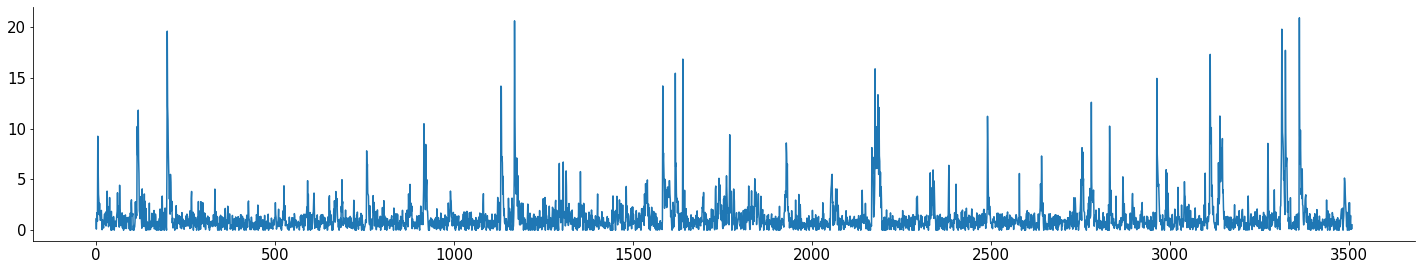

In [46]:
plt.plot(avgd_normed_dataRNN[1,:, 0])

issue: does the individual scaling by layer introduce bias that may artificially increase performance of the network?

## Data Loader 


In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.cuda.empty_cache()

In [49]:
torch.__version__

'1.9.0+cu102'

In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [51]:
# set the seed
np.random.seed(42)

# number of neurons 
NN = dataRNN.shape[0]

In [52]:
# swapping the axes to maintain consistency with seq2seq notebook in the following code - the network takes all the neurons at a time step as input, not just one neuron

# avgd_normed_dataRNN = np.swapaxes(avgd_normed_dataRNN, 0, 1)
avgd_normed_dataRNN.shape

(1131, 3509, 9)

In [53]:
frac = 4/5

#x1 = torch.from_numpy(dataRNN[:,:int(frac*dataRNN.shape[1])]).to(device).float().unsqueeze(0)
#x2 = torch.from_numpy(dataRNN[:,int(frac*dataRNN.shape[1]):]).to(device).float().unsqueeze(0)
#x1 = torch.from_numpy(avgd_normed_dataRNN[:1131,:]).to(device).float().unsqueeze(2)
#x2 = torch.from_numpy(avgd_normed_dataRNN[:1131,:]).to(device).float().unsqueeze(2)

#n_neurs = 1131
# let's use n_neurs/10 latent components
ncomp = 75 #int(n_neurs/10)

x1_train = torch.from_numpy(avgd_normed_dataRNN[:,:int(frac*avgd_normed_dataRNN.shape[1]), : ]).to(device).float()
x2_train = torch.from_numpy(avgd_normed_dataRNN[:,:int(frac*avgd_normed_dataRNN.shape[1]),: ]).to(device).float()

x1_valid = torch.from_numpy(avgd_normed_dataRNN[:,int(frac*avgd_normed_dataRNN.shape[1]):, :] ).to(device).float()
x2_valid = torch.from_numpy(avgd_normed_dataRNN[:,int(frac*avgd_normed_dataRNN.shape[1]):, :]).to(device).float()

NN1 = x1_train.shape[0]
NN2 = x2_train.shape[0]


In [56]:
class Net(nn.Module):
    def __init__(self, ncomp, NN1, NN2, bidi=True):
        super(Net, self).__init__()

        # play with some of the options in the RNN!
        
        self.rnn = nn.LSTM(NN1, ncomp, num_layers = 1, dropout = 0.2,
                         bidirectional = bidi)
        """
        self.rnn = nn.RNN(NN1, ncomp, num_layers = 1, dropout = 0,
                    bidirectional = bidi, nonlinearity = 'tanh')
        self.rnn = nn.GRU(NN1, ncomp, num_layers = 1, dropout = 0,
                         bidirectional = bidi)
        """
        
        self.mlp = nn.Sequential(
                    nn.Linear(ncomp, ncomp*2),
                    nn.Mish(),
                    nn.Linear(ncomp*2, ncomp*2),
                    nn.Mish(),
                    nn.Dropout(0.25),
                    nn.Linear(ncomp*2, ncomp), 
                    nn.Mish())
        
        self.fc = nn.Linear(ncomp, NN2)

    def forward(self, x):
        x = x.permute(1, 2, 0)
        #print(x.shape)
        # h_0 = torch.zeros(2, x.size()[1], self.ncomp).to(device)
        
        y, h_n = self.rnn(x)

        #print(y.shape)
        #print(h_n.shape)
        if self.rnn.bidirectional:
          # if the rnn is bidirectional, it concatenates the activations from the forward and backward pass
          # we want to add them instead, so as to enforce the latents to match between the forward and backward pass
            q = (y[:, :, :ncomp] + y[:, :, ncomp:])/2
        else:
            q = y
        
        q = self.mlp(q)

        # the softplus function is just like a relu but it's smoothed out so we can't predict 0
        # if we predict 0 and there was a spike, that's an instant Inf in the Poisson log-likelihood which leads to failure
        #z = F.softplus(self.fc(q), 10)
        #print(q.shape)
        z = self.fc(q).permute(2, 0, 1)
        # print(z.shape)
        return z, q

In [57]:
# we initialize the neural network
net = Net(ncomp, NN1, NN2, bidi = True).to(device)

# special thing:  we initialize the biases of the last layer in the neural network
# we set them as the mean firing rates of the neurons.
# this should make the initial predictions close to the mean, because the latents don't contribute much
# net.fc.bias.data[:] = x1_train.mean(axis = (0,1))

# we set up the optimizer. Adjust the learning rate if the training is slow or if it explodes.
optimizer1 = torch.optim.Adam(net.parameters(), lr= 0.0003795, weight_decay= 10e-6)
# optimizer2 = torch.optim.SGD(net.parameters(), lr = 0.0001, momentum = 0.9, weight_decay = 0.01, )
# optimizer3 = torch.optim.

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [58]:
# forward check 
# net(x1)
net(x1_train)

(tensor([[[ 0.0645,  0.0642,  0.0581,  ...,  0.0466,  0.0685,  0.0502],
          [ 0.0468,  0.0544,  0.0621,  ...,  0.0543,  0.0617,  0.0695],
          [ 0.0576,  0.0554,  0.0530,  ...,  0.0499,  0.0514,  0.0630],
          ...,
          [ 0.0538,  0.0605,  0.0645,  ...,  0.0599,  0.0568,  0.0579],
          [ 0.0620,  0.0727,  0.0733,  ...,  0.0568,  0.0628,  0.0596],
          [ 0.0692,  0.0668,  0.0664,  ...,  0.0574,  0.0654,  0.0683]],
 
         [[ 0.0082,  0.0077,  0.0166,  ...,  0.0162,  0.0086,  0.0161],
          [ 0.0107,  0.0104,  0.0111,  ...,  0.0188,  0.0188,  0.0134],
          [ 0.0131,  0.0182,  0.0070,  ...,  0.0099,  0.0261,  0.0048],
          ...,
          [ 0.0058,  0.0114, -0.0039,  ...,  0.0248,  0.0196, -0.0029],
          [ 0.0081,  0.0159,  0.0038,  ...,  0.0228,  0.0028,  0.0100],
          [ 0.0079,  0.0168, -0.0009,  ...,  0.0207,  0.0102,  0.0116]],
 
         [[-0.0720, -0.0568, -0.0709,  ..., -0.0589, -0.0633, -0.0656],
          [-0.0674, -0.0588,

## Training 

In [59]:
from tqdm import tqdm

In [66]:
from sam import SAM

base_optimizer = torch.optim.Adam  # define an optimizer for the "sharpness-aware" update
optimizer = SAM(net.parameters(), base_optimizer, lr=0.000375, weight_decay = 10e-6)#, momentum=0.9)

# you can keep re-running this cell if you think the cost might decrease further

cost = nn.MSELoss()

#train_save = []
#valid_save = []

niter = 100000 #+30000 # 
# rnn_loss = 0.2372, lstm_loss = 0.2340, gru_lstm = 0.2370
for k in tqdm(range(niter)):
    net.train()
    # the network outputs the single-neuron prediction and the latents
    z, y = net(x1_train)

    # our cost
    loss = cost(z, x2_train)

    # train the network as usual
    loss.backward()
    optimizer.first_step(zero_grad = True)
    cost(net(x1_train)[0],x2_train).backward()
    
    optimizer.second_step(zero_grad=True)
    
    """
    # this can be run in a first phase, before wandb finetuning
    with torch.no_grad():
        net.eval()
        train_save.append(loss.item())
        valid_loss = cost(net(x1_valid)[0], x2_valid)
        valid_save.append(valid_loss.item())
    """;

    if k % 50 == 0:
        with torch.no_grad():
            net.eval()
            valid_loss = cost(net(x1_valid)[0], x2_valid)
            
            print(f' iteration {k}, train cost {loss.item():.4f}, valid cost {valid_loss.item():.4f}')

  0%|          | 1/100000 [00:00<11:09:43,  2.49it/s]

 iteration 0, train cost 1.5101, valid cost 1.5716


  0%|          | 51/100000 [00:19<10:35:39,  2.62it/s]

 iteration 50, train cost 1.5102, valid cost 1.5375


  0%|          | 101/100000 [00:38<10:45:33,  2.58it/s]

 iteration 100, train cost 1.5101, valid cost 1.5374


  0%|          | 151/100000 [00:57<10:50:06,  2.56it/s]

 iteration 150, train cost 1.5099, valid cost 1.5375


  0%|          | 201/100000 [01:16<10:51:14,  2.55it/s]

 iteration 200, train cost 1.5101, valid cost 1.5375


  0%|          | 251/100000 [01:35<10:43:33,  2.58it/s]

 iteration 250, train cost 1.5099, valid cost 1.5376


  0%|          | 301/100000 [01:53<10:33:22,  2.62it/s]

 iteration 300, train cost 1.5102, valid cost 1.5376


  0%|          | 351/100000 [02:12<10:56:32,  2.53it/s]

 iteration 350, train cost 1.5101, valid cost 1.5374


  0%|          | 401/100000 [02:32<10:57:53,  2.52it/s]

 iteration 400, train cost 1.5102, valid cost 1.5376


  0%|          | 451/100000 [02:51<10:59:33,  2.52it/s]

 iteration 450, train cost 1.5102, valid cost 1.5375


  1%|          | 501/100000 [03:09<10:31:52,  2.62it/s]

 iteration 500, train cost 1.5102, valid cost 1.5375


  1%|          | 551/100000 [03:28<10:48:11,  2.56it/s]

 iteration 550, train cost 1.5099, valid cost 1.5376


  1%|          | 601/100000 [03:47<10:46:23,  2.56it/s]

 iteration 600, train cost 1.5100, valid cost 1.5375


  1%|          | 651/100000 [04:06<10:42:48,  2.58it/s]

 iteration 650, train cost 1.5100, valid cost 1.5375


  1%|          | 701/100000 [04:25<10:46:47,  2.56it/s]

 iteration 700, train cost 1.5102, valid cost 1.5375


  1%|          | 751/100000 [04:44<10:42:46,  2.57it/s]

 iteration 750, train cost 1.5100, valid cost 1.5375


  1%|          | 801/100000 [05:03<10:38:02,  2.59it/s]

 iteration 800, train cost 1.5100, valid cost 1.5375


  1%|          | 851/100000 [05:22<10:57:33,  2.51it/s]

 iteration 850, train cost 1.5100, valid cost 1.5374


  1%|          | 901/100000 [05:41<10:32:51,  2.61it/s]

 iteration 900, train cost 1.5102, valid cost 1.5375


  1%|          | 951/100000 [05:59<10:34:56,  2.60it/s]

 iteration 950, train cost 1.5099, valid cost 1.5375


  1%|          | 1001/100000 [06:18<10:40:19,  2.58it/s]

 iteration 1000, train cost 1.5101, valid cost 1.5376


  1%|          | 1051/100000 [06:37<10:41:58,  2.57it/s]

 iteration 1050, train cost 1.5099, valid cost 1.5376


  1%|          | 1101/100000 [06:56<10:46:27,  2.55it/s]

 iteration 1100, train cost 1.5102, valid cost 1.5374


  1%|          | 1151/100000 [07:14<10:32:23,  2.61it/s]

 iteration 1150, train cost 1.5097, valid cost 1.5375


  1%|          | 1201/100000 [07:34<10:45:49,  2.55it/s]

 iteration 1200, train cost 1.5101, valid cost 1.5376


  1%|▏         | 1251/100000 [07:53<10:37:35,  2.58it/s]

 iteration 1250, train cost 1.5099, valid cost 1.5376


  1%|▏         | 1301/100000 [08:12<10:48:53,  2.54it/s]

 iteration 1300, train cost 1.5104, valid cost 1.5374


  1%|▏         | 1351/100000 [08:30<10:41:55,  2.56it/s]

 iteration 1350, train cost 1.5100, valid cost 1.5375


  1%|▏         | 1401/100000 [08:49<10:32:50,  2.60it/s]

 iteration 1400, train cost 1.5100, valid cost 1.5375


  1%|▏         | 1451/100000 [09:08<10:25:05,  2.63it/s]

 iteration 1450, train cost 1.5101, valid cost 1.5375


  2%|▏         | 1501/100000 [09:26<10:27:37,  2.62it/s]

 iteration 1500, train cost 1.5099, valid cost 1.5375


  2%|▏         | 1551/100000 [09:45<10:40:41,  2.56it/s]

 iteration 1550, train cost 1.5099, valid cost 1.5375


  2%|▏         | 1601/100000 [10:04<10:24:44,  2.63it/s]

 iteration 1600, train cost 1.5100, valid cost 1.5375


  2%|▏         | 1651/100000 [10:23<10:38:21,  2.57it/s]

 iteration 1650, train cost 1.5101, valid cost 1.5374


  2%|▏         | 1701/100000 [10:42<10:47:37,  2.53it/s]

 iteration 1700, train cost 1.5101, valid cost 1.5374


  2%|▏         | 1751/100000 [11:01<10:43:54,  2.54it/s]

 iteration 1750, train cost 1.5099, valid cost 1.5375


  2%|▏         | 1801/100000 [11:20<10:42:26,  2.55it/s]

 iteration 1800, train cost 1.5102, valid cost 1.5374


  2%|▏         | 1851/100000 [11:39<10:30:54,  2.59it/s]

 iteration 1850, train cost 1.5100, valid cost 1.5375


  2%|▏         | 1901/100000 [11:57<10:27:53,  2.60it/s]

 iteration 1900, train cost 1.5098, valid cost 1.5374


  2%|▏         | 1951/100000 [12:16<10:29:10,  2.60it/s]

 iteration 1950, train cost 1.5100, valid cost 1.5374


  2%|▏         | 2001/100000 [12:35<10:41:21,  2.55it/s]

 iteration 2000, train cost 1.5099, valid cost 1.5374


  2%|▏         | 2051/100000 [12:54<10:42:38,  2.54it/s]

 iteration 2050, train cost 1.5101, valid cost 1.5375


  2%|▏         | 2101/100000 [13:13<10:33:43,  2.57it/s]

 iteration 2100, train cost 1.5100, valid cost 1.5375


  2%|▏         | 2151/100000 [13:32<10:32:15,  2.58it/s]

 iteration 2150, train cost 1.5098, valid cost 1.5374


  2%|▏         | 2201/100000 [13:51<10:34:36,  2.57it/s]

 iteration 2200, train cost 1.5097, valid cost 1.5374


  2%|▏         | 2251/100000 [14:10<10:30:41,  2.58it/s]

 iteration 2250, train cost 1.5098, valid cost 1.5374


  2%|▏         | 2301/100000 [14:29<10:28:09,  2.59it/s]

 iteration 2300, train cost 1.5100, valid cost 1.5374


  2%|▏         | 2351/100000 [14:48<10:46:48,  2.52it/s]

 iteration 2350, train cost 1.5099, valid cost 1.5374


  2%|▏         | 2401/100000 [15:07<10:23:47,  2.61it/s]

 iteration 2400, train cost 1.5099, valid cost 1.5374


  2%|▏         | 2451/100000 [15:25<10:30:10,  2.58it/s]

 iteration 2450, train cost 1.5098, valid cost 1.5374


  3%|▎         | 2501/100000 [15:44<9:53:35,  2.74it/s] 

 iteration 2500, train cost 1.5098, valid cost 1.5375


  3%|▎         | 2551/100000 [16:02<10:34:57,  2.56it/s]

 iteration 2550, train cost 1.5099, valid cost 1.5374


  3%|▎         | 2601/100000 [16:22<10:35:19,  2.56it/s]

 iteration 2600, train cost 1.5101, valid cost 1.5374


  3%|▎         | 2651/100000 [16:41<10:50:14,  2.50it/s]

 iteration 2650, train cost 1.5101, valid cost 1.5375


  3%|▎         | 2701/100000 [17:00<10:43:10,  2.52it/s]

 iteration 2700, train cost 1.5100, valid cost 1.5374


  3%|▎         | 2751/100000 [17:20<10:52:18,  2.48it/s]

 iteration 2750, train cost 1.5096, valid cost 1.5375


  3%|▎         | 2801/100000 [17:39<10:40:50,  2.53it/s]

 iteration 2800, train cost 1.5099, valid cost 1.5374


  3%|▎         | 2851/100000 [17:58<10:34:53,  2.55it/s]

 iteration 2850, train cost 1.5099, valid cost 1.5373


  3%|▎         | 2901/100000 [18:17<10:34:40,  2.55it/s]

 iteration 2900, train cost 1.5100, valid cost 1.5374


  3%|▎         | 2951/100000 [18:36<10:37:26,  2.54it/s]

 iteration 2950, train cost 1.5100, valid cost 1.5374


  3%|▎         | 3001/100000 [18:56<10:54:43,  2.47it/s]

 iteration 3000, train cost 1.5099, valid cost 1.5374


  3%|▎         | 3051/100000 [19:15<10:35:34,  2.54it/s]

 iteration 3050, train cost 1.5100, valid cost 1.5373


  3%|▎         | 3101/100000 [19:34<10:20:58,  2.60it/s]

 iteration 3100, train cost 1.5100, valid cost 1.5374


  3%|▎         | 3151/100000 [19:54<10:42:40,  2.51it/s]

 iteration 3150, train cost 1.5098, valid cost 1.5374


  3%|▎         | 3201/100000 [20:13<10:32:56,  2.55it/s]

 iteration 3200, train cost 1.5100, valid cost 1.5373


  3%|▎         | 3251/100000 [20:32<10:44:46,  2.50it/s]

 iteration 3250, train cost 1.5098, valid cost 1.5374


  3%|▎         | 3301/100000 [20:51<10:35:00,  2.54it/s]

 iteration 3300, train cost 1.5097, valid cost 1.5373


  3%|▎         | 3351/100000 [21:10<10:38:49,  2.52it/s]

 iteration 3350, train cost 1.5097, valid cost 1.5373


  3%|▎         | 3401/100000 [21:30<10:45:06,  2.50it/s]

 iteration 3400, train cost 1.5099, valid cost 1.5373


  3%|▎         | 3451/100000 [21:49<10:39:41,  2.52it/s]

 iteration 3450, train cost 1.5099, valid cost 1.5373


  4%|▎         | 3501/100000 [22:09<10:49:14,  2.48it/s]

 iteration 3500, train cost 1.5098, valid cost 1.5374


  4%|▎         | 3551/100000 [22:28<10:38:54,  2.52it/s]

 iteration 3550, train cost 1.5100, valid cost 1.5374


  4%|▎         | 3601/100000 [22:47<10:39:23,  2.51it/s]

 iteration 3600, train cost 1.5101, valid cost 1.5373


  4%|▎         | 3651/100000 [23:07<10:46:18,  2.48it/s]

 iteration 3650, train cost 1.5099, valid cost 1.5374


  4%|▎         | 3701/100000 [23:26<10:20:36,  2.59it/s]

 iteration 3700, train cost 1.5099, valid cost 1.5373


  4%|▍         | 3751/100000 [23:45<10:55:44,  2.45it/s]

 iteration 3750, train cost 1.5098, valid cost 1.5373


  4%|▍         | 3801/100000 [24:04<10:30:26,  2.54it/s]

 iteration 3800, train cost 1.5097, valid cost 1.5373


  4%|▍         | 3851/100000 [24:24<10:35:54,  2.52it/s]

 iteration 3850, train cost 1.5099, valid cost 1.5373


  4%|▍         | 3901/100000 [24:43<10:35:34,  2.52it/s]

 iteration 3900, train cost 1.5100, valid cost 1.5374


  4%|▍         | 3951/100000 [25:02<10:38:59,  2.51it/s]

 iteration 3950, train cost 1.5097, valid cost 1.5375


  4%|▍         | 4001/100000 [25:22<10:38:52,  2.50it/s]

 iteration 4000, train cost 1.5099, valid cost 1.5375


  4%|▍         | 4051/100000 [25:41<10:32:13,  2.53it/s]

 iteration 4050, train cost 1.5098, valid cost 1.5374


  4%|▍         | 4101/100000 [26:00<10:37:10,  2.51it/s]

 iteration 4100, train cost 1.5099, valid cost 1.5373


  4%|▍         | 4151/100000 [26:20<10:45:53,  2.47it/s]

 iteration 4150, train cost 1.5099, valid cost 1.5373


  4%|▍         | 4201/100000 [26:39<10:24:09,  2.56it/s]

 iteration 4200, train cost 1.5101, valid cost 1.5372


  4%|▍         | 4251/100000 [26:58<10:38:59,  2.50it/s]

 iteration 4250, train cost 1.5099, valid cost 1.5374


  4%|▍         | 4301/100000 [27:18<10:31:21,  2.53it/s]

 iteration 4300, train cost 1.5099, valid cost 1.5373


  4%|▍         | 4351/100000 [27:37<10:40:36,  2.49it/s]

 iteration 4350, train cost 1.5100, valid cost 1.5374


  4%|▍         | 4401/100000 [27:56<10:37:56,  2.50it/s]

 iteration 4400, train cost 1.5098, valid cost 1.5373


  4%|▍         | 4451/100000 [28:16<10:29:27,  2.53it/s]

 iteration 4450, train cost 1.5100, valid cost 1.5374


  5%|▍         | 4501/100000 [28:35<10:35:50,  2.50it/s]

 iteration 4500, train cost 1.5097, valid cost 1.5373


  5%|▍         | 4551/100000 [28:54<10:21:53,  2.56it/s]

 iteration 4550, train cost 1.5099, valid cost 1.5373


  5%|▍         | 4601/100000 [29:13<10:28:53,  2.53it/s]

 iteration 4600, train cost 1.5099, valid cost 1.5372


  5%|▍         | 4651/100000 [29:33<10:36:15,  2.50it/s]

 iteration 4650, train cost 1.5100, valid cost 1.5372


  5%|▍         | 4701/100000 [29:52<10:28:17,  2.53it/s]

 iteration 4700, train cost 1.5098, valid cost 1.5372


  5%|▍         | 4751/100000 [30:11<10:36:02,  2.50it/s]

 iteration 4750, train cost 1.5101, valid cost 1.5372


  5%|▍         | 4801/100000 [30:30<10:28:06,  2.53it/s]

 iteration 4800, train cost 1.5098, valid cost 1.5373


  5%|▍         | 4851/100000 [30:50<10:32:24,  2.51it/s]

 iteration 4850, train cost 1.5098, valid cost 1.5372


  5%|▍         | 4901/100000 [31:09<10:27:24,  2.53it/s]

 iteration 4900, train cost 1.5100, valid cost 1.5372


  5%|▍         | 4951/100000 [31:28<10:39:56,  2.48it/s]

 iteration 4950, train cost 1.5098, valid cost 1.5372


  5%|▌         | 5001/100000 [31:48<10:33:47,  2.50it/s]

 iteration 5000, train cost 1.5101, valid cost 1.5372


  5%|▌         | 5051/100000 [32:07<10:24:35,  2.53it/s]

 iteration 5050, train cost 1.5097, valid cost 1.5373


  5%|▌         | 5101/100000 [32:27<10:26:58,  2.52it/s]

 iteration 5100, train cost 1.5097, valid cost 1.5372


  5%|▌         | 5151/100000 [32:46<10:37:16,  2.48it/s]

 iteration 5150, train cost 1.5098, valid cost 1.5372


  5%|▌         | 5201/100000 [33:05<10:27:19,  2.52it/s]

 iteration 5200, train cost 1.5098, valid cost 1.5372


  5%|▌         | 5251/100000 [33:25<10:35:27,  2.49it/s]

 iteration 5250, train cost 1.5100, valid cost 1.5373


  5%|▌         | 5301/100000 [33:44<10:24:19,  2.53it/s]

 iteration 5300, train cost 1.5100, valid cost 1.5372


  5%|▌         | 5351/100000 [34:03<10:28:56,  2.51it/s]

 iteration 5350, train cost 1.5097, valid cost 1.5373


  5%|▌         | 5401/100000 [34:23<10:31:42,  2.50it/s]

 iteration 5400, train cost 1.5099, valid cost 1.5373


  5%|▌         | 5451/100000 [34:42<10:25:39,  2.52it/s]

 iteration 5450, train cost 1.5099, valid cost 1.5372


  6%|▌         | 5501/100000 [35:02<10:32:56,  2.49it/s]

 iteration 5500, train cost 1.5096, valid cost 1.5372


  6%|▌         | 5551/100000 [35:21<10:20:37,  2.54it/s]

 iteration 5550, train cost 1.5099, valid cost 1.5373


  6%|▌         | 5601/100000 [35:40<10:20:26,  2.54it/s]

 iteration 5600, train cost 1.5098, valid cost 1.5372


  6%|▌         | 5651/100000 [36:00<10:29:42,  2.50it/s]

 iteration 5650, train cost 1.5098, valid cost 1.5374


  6%|▌         | 5701/100000 [36:19<10:20:05,  2.53it/s]

 iteration 5700, train cost 1.5097, valid cost 1.5372


  6%|▌         | 5751/100000 [36:38<10:24:48,  2.51it/s]

 iteration 5750, train cost 1.5099, valid cost 1.5372


  6%|▌         | 5801/100000 [36:57<10:24:50,  2.51it/s]

 iteration 5800, train cost 1.5098, valid cost 1.5372


  6%|▌         | 5851/100000 [37:17<10:32:01,  2.48it/s]

 iteration 5850, train cost 1.5097, valid cost 1.5372


  6%|▌         | 5901/100000 [37:36<10:04:57,  2.59it/s]

 iteration 5900, train cost 1.5098, valid cost 1.5373


  6%|▌         | 5951/100000 [37:55<10:25:54,  2.50it/s]

 iteration 5950, train cost 1.5098, valid cost 1.5372


  6%|▌         | 6001/100000 [38:14<10:26:06,  2.50it/s]

 iteration 6000, train cost 1.5097, valid cost 1.5372


  6%|▌         | 6051/100000 [38:34<10:21:12,  2.52it/s]

 iteration 6050, train cost 1.5099, valid cost 1.5371


  6%|▌         | 6101/100000 [38:53<10:26:03,  2.50it/s]

 iteration 6100, train cost 1.5101, valid cost 1.5372


  6%|▌         | 6151/100000 [39:12<10:12:02,  2.56it/s]

 iteration 6150, train cost 1.5097, valid cost 1.5372


  6%|▌         | 6201/100000 [39:32<10:22:11,  2.51it/s]

 iteration 6200, train cost 1.5100, valid cost 1.5371


  6%|▋         | 6251/100000 [39:51<10:20:55,  2.52it/s]

 iteration 6250, train cost 1.5098, valid cost 1.5372


  6%|▋         | 6301/100000 [40:10<10:18:43,  2.52it/s]

 iteration 6300, train cost 1.5096, valid cost 1.5373


  6%|▋         | 6351/100000 [40:30<10:24:45,  2.50it/s]

 iteration 6350, train cost 1.5094, valid cost 1.5372


  6%|▋         | 6401/100000 [40:48<10:06:25,  2.57it/s]

 iteration 6400, train cost 1.5099, valid cost 1.5371


  6%|▋         | 6451/100000 [41:08<10:20:46,  2.51it/s]

 iteration 6450, train cost 1.5098, valid cost 1.5372


  7%|▋         | 6501/100000 [41:27<10:22:38,  2.50it/s]

 iteration 6500, train cost 1.5096, valid cost 1.5372


  7%|▋         | 6551/100000 [41:46<10:16:18,  2.53it/s]

 iteration 6550, train cost 1.5098, valid cost 1.5372


  7%|▋         | 6601/100000 [42:06<10:29:50,  2.47it/s]

 iteration 6600, train cost 1.5098, valid cost 1.5372


  7%|▋         | 6651/100000 [42:25<10:01:53,  2.58it/s]

 iteration 6650, train cost 1.5099, valid cost 1.5371


  7%|▋         | 6701/100000 [42:44<10:21:55,  2.50it/s]

 iteration 6700, train cost 1.5097, valid cost 1.5372


  7%|▋         | 6751/100000 [43:04<10:20:18,  2.51it/s]

 iteration 6750, train cost 1.5095, valid cost 1.5372


  7%|▋         | 6801/100000 [43:23<10:16:55,  2.52it/s]

 iteration 6800, train cost 1.5098, valid cost 1.5371


  7%|▋         | 6851/100000 [43:42<10:06:30,  2.56it/s]

 iteration 6850, train cost 1.5096, valid cost 1.5372


  7%|▋         | 6901/100000 [44:01<10:14:36,  2.52it/s]

 iteration 6900, train cost 1.5095, valid cost 1.5372


  7%|▋         | 6951/100000 [44:20<10:14:42,  2.52it/s]

 iteration 6950, train cost 1.5098, valid cost 1.5371


  7%|▋         | 7001/100000 [44:40<10:13:07,  2.53it/s]

 iteration 7000, train cost 1.5098, valid cost 1.5371


  7%|▋         | 7051/100000 [44:59<10:11:35,  2.53it/s]

 iteration 7050, train cost 1.5097, valid cost 1.5371


  7%|▋         | 7101/100000 [45:18<10:16:11,  2.51it/s]

 iteration 7100, train cost 1.5094, valid cost 1.5372


  7%|▋         | 7151/100000 [45:38<10:21:21,  2.49it/s]

 iteration 7150, train cost 1.5097, valid cost 1.5371


  7%|▋         | 7201/100000 [45:57<10:15:05,  2.51it/s]

 iteration 7200, train cost 1.5096, valid cost 1.5371


  7%|▋         | 7251/100000 [46:16<10:07:55,  2.54it/s]

 iteration 7250, train cost 1.5096, valid cost 1.5371


  7%|▋         | 7301/100000 [46:35<10:12:03,  2.52it/s]

 iteration 7300, train cost 1.5095, valid cost 1.5371


  7%|▋         | 7351/100000 [46:55<10:16:02,  2.51it/s]

 iteration 7350, train cost 1.5098, valid cost 1.5371


  7%|▋         | 7401/100000 [47:14<10:17:46,  2.50it/s]

 iteration 7400, train cost 1.5099, valid cost 1.5371


  7%|▋         | 7451/100000 [47:33<10:09:07,  2.53it/s]

 iteration 7450, train cost 1.5097, valid cost 1.5370


  8%|▊         | 7501/100000 [47:52<10:09:26,  2.53it/s]

 iteration 7500, train cost 1.5098, valid cost 1.5370


  8%|▊         | 7551/100000 [48:12<10:09:05,  2.53it/s]

 iteration 7550, train cost 1.5098, valid cost 1.5371


  8%|▊         | 7601/100000 [48:31<10:11:06,  2.52it/s]

 iteration 7600, train cost 1.5096, valid cost 1.5371


  8%|▊         | 7651/100000 [48:50<10:07:36,  2.53it/s]

 iteration 7650, train cost 1.5096, valid cost 1.5372


  8%|▊         | 7701/100000 [49:09<9:49:37,  2.61it/s] 

 iteration 7700, train cost 1.5097, valid cost 1.5371


  8%|▊         | 7751/100000 [49:28<10:11:12,  2.52it/s]

 iteration 7750, train cost 1.5099, valid cost 1.5370


  8%|▊         | 7801/100000 [49:48<10:04:48,  2.54it/s]

 iteration 7800, train cost 1.5097, valid cost 1.5371


  8%|▊         | 7851/100000 [50:07<10:07:29,  2.53it/s]

 iteration 7850, train cost 1.5094, valid cost 1.5371


  8%|▊         | 7901/100000 [50:26<10:09:48,  2.52it/s]

 iteration 7900, train cost 1.5098, valid cost 1.5370


  8%|▊         | 7951/100000 [50:45<9:54:14,  2.58it/s] 

 iteration 7950, train cost 1.5095, valid cost 1.5371


  8%|▊         | 8001/100000 [51:04<10:06:59,  2.53it/s]

 iteration 8000, train cost 1.5096, valid cost 1.5371


  8%|▊         | 8051/100000 [51:23<10:07:32,  2.52it/s]

 iteration 8050, train cost 1.5095, valid cost 1.5370


  8%|▊         | 8101/100000 [51:42<10:11:35,  2.50it/s]

 iteration 8100, train cost 1.5098, valid cost 1.5371


  8%|▊         | 8151/100000 [52:02<10:07:11,  2.52it/s]

 iteration 8150, train cost 1.5098, valid cost 1.5371


  8%|▊         | 8201/100000 [52:20<9:53:06,  2.58it/s] 

 iteration 8200, train cost 1.5098, valid cost 1.5370


  8%|▊         | 8251/100000 [52:40<10:03:02,  2.54it/s]

 iteration 8250, train cost 1.5096, valid cost 1.5371


  8%|▊         | 8301/100000 [52:59<10:01:16,  2.54it/s]

 iteration 8300, train cost 1.5096, valid cost 1.5370


  8%|▊         | 8351/100000 [53:18<10:01:19,  2.54it/s]

 iteration 8350, train cost 1.5098, valid cost 1.5371


  8%|▊         | 8401/100000 [53:37<10:06:07,  2.52it/s]

 iteration 8400, train cost 1.5098, valid cost 1.5371


  8%|▊         | 8451/100000 [53:56<9:51:17,  2.58it/s] 

 iteration 8450, train cost 1.5096, valid cost 1.5370


  9%|▊         | 8501/100000 [54:15<9:59:52,  2.54it/s]

 iteration 8500, train cost 1.5095, valid cost 1.5371


  9%|▊         | 8551/100000 [54:34<10:01:10,  2.54it/s]

 iteration 8550, train cost 1.5096, valid cost 1.5370


  9%|▊         | 8601/100000 [54:53<9:47:54,  2.59it/s] 

 iteration 8600, train cost 1.5095, valid cost 1.5371


  9%|▊         | 8651/100000 [55:13<10:02:31,  2.53it/s]

 iteration 8650, train cost 1.5096, valid cost 1.5371


  9%|▊         | 8701/100000 [55:31<9:48:03,  2.59it/s] 

 iteration 8700, train cost 1.5096, valid cost 1.5370


  9%|▉         | 8751/100000 [55:51<9:58:26,  2.54it/s]

 iteration 8750, train cost 1.5097, valid cost 1.5370


  9%|▉         | 8801/100000 [56:10<10:04:56,  2.51it/s]

 iteration 8800, train cost 1.5097, valid cost 1.5370


  9%|▉         | 8851/100000 [56:29<10:10:02,  2.49it/s]

 iteration 8850, train cost 1.5097, valid cost 1.5370


  9%|▉         | 8901/100000 [56:48<9:57:49,  2.54it/s] 

 iteration 8900, train cost 1.5096, valid cost 1.5371


  9%|▉         | 8951/100000 [57:07<9:47:36,  2.58it/s]

 iteration 8950, train cost 1.5097, valid cost 1.5371


  9%|▉         | 9001/100000 [57:26<10:02:53,  2.52it/s]

 iteration 9000, train cost 1.5098, valid cost 1.5370


  9%|▉         | 9051/100000 [57:46<10:07:14,  2.50it/s]

 iteration 9050, train cost 1.5096, valid cost 1.5370


  9%|▉         | 9101/100000 [58:05<9:57:46,  2.53it/s] 

 iteration 9100, train cost 1.5096, valid cost 1.5370


  9%|▉         | 9151/100000 [58:24<10:00:24,  2.52it/s]

 iteration 9150, train cost 1.5094, valid cost 1.5370


  9%|▉         | 9201/100000 [58:43<9:45:10,  2.59it/s] 

 iteration 9200, train cost 1.5099, valid cost 1.5370


  9%|▉         | 9251/100000 [59:02<9:43:51,  2.59it/s]

 iteration 9250, train cost 1.5096, valid cost 1.5370


  9%|▉         | 9301/100000 [59:21<9:52:29,  2.55it/s]

 iteration 9300, train cost 1.5098, valid cost 1.5370


  9%|▉         | 9351/100000 [59:40<9:58:49,  2.52it/s]

 iteration 9350, train cost 1.5096, valid cost 1.5370


  9%|▉         | 9401/100000 [59:59<9:56:08,  2.53it/s]

 iteration 9400, train cost 1.5098, valid cost 1.5370


  9%|▉         | 9451/100000 [1:00:18<9:46:00,  2.58it/s]

 iteration 9450, train cost 1.5095, valid cost 1.5370


 10%|▉         | 9501/100000 [1:00:37<9:57:19,  2.53it/s]

 iteration 9500, train cost 1.5097, valid cost 1.5371


 10%|▉         | 9551/100000 [1:00:57<9:56:20,  2.53it/s]

 iteration 9550, train cost 1.5095, valid cost 1.5370


 10%|▉         | 9601/100000 [1:01:16<9:55:39,  2.53it/s]

 iteration 9600, train cost 1.5096, valid cost 1.5370


 10%|▉         | 9651/100000 [1:01:35<9:57:03,  2.52it/s]

 iteration 9650, train cost 1.5096, valid cost 1.5371


 10%|▉         | 9701/100000 [1:01:54<9:37:02,  2.61it/s]

 iteration 9700, train cost 1.5097, valid cost 1.5370


 10%|▉         | 9751/100000 [1:02:13<9:50:58,  2.55it/s]

 iteration 9750, train cost 1.5096, valid cost 1.5371


 10%|▉         | 9801/100000 [1:02:32<10:01:04,  2.50it/s]

 iteration 9800, train cost 1.5095, valid cost 1.5371


 10%|▉         | 9851/100000 [1:02:51<9:57:58,  2.51it/s] 

 iteration 9850, train cost 1.5098, valid cost 1.5370


 10%|▉         | 9901/100000 [1:03:11<9:54:41,  2.53it/s]

 iteration 9900, train cost 1.5095, valid cost 1.5370


 10%|▉         | 9951/100000 [1:03:30<9:39:57,  2.59it/s]

 iteration 9950, train cost 1.5095, valid cost 1.5370


 10%|█         | 10001/100000 [1:03:49<9:51:09,  2.54it/s]

 iteration 10000, train cost 1.5097, valid cost 1.5371


 10%|█         | 10051/100000 [1:04:08<9:55:39,  2.52it/s]

 iteration 10050, train cost 1.5097, valid cost 1.5371


 10%|█         | 10101/100000 [1:04:27<9:57:35,  2.51it/s]

 iteration 10100, train cost 1.5097, valid cost 1.5369


 10%|█         | 10151/100000 [1:04:46<9:51:27,  2.53it/s]

 iteration 10150, train cost 1.5095, valid cost 1.5371


 10%|█         | 10201/100000 [1:05:05<9:40:52,  2.58it/s]

 iteration 10200, train cost 1.5097, valid cost 1.5370


 10%|█         | 10251/100000 [1:05:24<9:51:43,  2.53it/s]

 iteration 10250, train cost 1.5095, valid cost 1.5370


 10%|█         | 10301/100000 [1:05:44<9:56:26,  2.51it/s]

 iteration 10300, train cost 1.5098, valid cost 1.5370


 10%|█         | 10351/100000 [1:06:03<9:51:58,  2.52it/s]

 iteration 10350, train cost 1.5094, valid cost 1.5370


 10%|█         | 10401/100000 [1:06:22<9:50:59,  2.53it/s]

 iteration 10400, train cost 1.5097, valid cost 1.5369


 10%|█         | 10451/100000 [1:06:41<9:42:36,  2.56it/s]

 iteration 10450, train cost 1.5095, valid cost 1.5371


 11%|█         | 10501/100000 [1:07:00<9:42:56,  2.56it/s]

 iteration 10500, train cost 1.5096, valid cost 1.5370


 11%|█         | 10551/100000 [1:07:19<9:52:06,  2.52it/s]

 iteration 10550, train cost 1.5097, valid cost 1.5369


 11%|█         | 10601/100000 [1:07:39<9:46:15,  2.54it/s]

 iteration 10600, train cost 1.5094, valid cost 1.5370


 11%|█         | 10651/100000 [1:07:58<9:53:21,  2.51it/s]

 iteration 10650, train cost 1.5092, valid cost 1.5369


 11%|█         | 10701/100000 [1:08:17<9:34:42,  2.59it/s]

 iteration 10700, train cost 1.5096, valid cost 1.5369


 11%|█         | 10751/100000 [1:08:36<9:45:11,  2.54it/s]

 iteration 10750, train cost 1.5096, valid cost 1.5369


 11%|█         | 10801/100000 [1:08:55<9:43:52,  2.55it/s]

 iteration 10800, train cost 1.5096, valid cost 1.5369


 11%|█         | 10851/100000 [1:09:14<9:55:45,  2.49it/s]

 iteration 10850, train cost 1.5094, valid cost 1.5369


 11%|█         | 10901/100000 [1:09:33<9:48:36,  2.52it/s]

 iteration 10900, train cost 1.5097, valid cost 1.5369


 11%|█         | 10951/100000 [1:09:52<9:33:51,  2.59it/s]

 iteration 10950, train cost 1.5094, valid cost 1.5370


 11%|█         | 11001/100000 [1:10:11<9:48:45,  2.52it/s]

 iteration 11000, train cost 1.5097, valid cost 1.5370


 11%|█         | 11051/100000 [1:10:31<9:45:27,  2.53it/s]

 iteration 11050, train cost 1.5095, valid cost 1.5369


 11%|█         | 11101/100000 [1:10:50<9:40:06,  2.55it/s]

 iteration 11100, train cost 1.5099, valid cost 1.5369


 11%|█         | 11151/100000 [1:11:09<9:46:37,  2.52it/s]

 iteration 11150, train cost 1.5098, valid cost 1.5370


 11%|█         | 11201/100000 [1:11:28<9:28:09,  2.60it/s]

 iteration 11200, train cost 1.5096, valid cost 1.5368


 11%|█▏        | 11251/100000 [1:11:48<9:52:46,  2.50it/s]

 iteration 11250, train cost 1.5095, valid cost 1.5369


 11%|█▏        | 11301/100000 [1:12:06<9:27:52,  2.60it/s]

 iteration 11300, train cost 1.5094, valid cost 1.5370


 11%|█▏        | 11351/100000 [1:12:25<9:33:46,  2.58it/s]

 iteration 11350, train cost 1.5095, valid cost 1.5369


 11%|█▏        | 11401/100000 [1:12:45<9:44:26,  2.53it/s]

 iteration 11400, train cost 1.5094, valid cost 1.5368


 11%|█▏        | 11451/100000 [1:13:03<9:26:10,  2.61it/s]

 iteration 11450, train cost 1.5096, valid cost 1.5370


 12%|█▏        | 11501/100000 [1:13:23<9:49:54,  2.50it/s]

 iteration 11500, train cost 1.5094, valid cost 1.5369


 12%|█▏        | 11551/100000 [1:13:42<9:30:39,  2.58it/s]

 iteration 11550, train cost 1.5093, valid cost 1.5369


 12%|█▏        | 11601/100000 [1:14:00<9:33:38,  2.57it/s]

 iteration 11600, train cost 1.5097, valid cost 1.5369


 12%|█▏        | 11651/100000 [1:14:20<9:45:59,  2.51it/s]

 iteration 11650, train cost 1.5095, valid cost 1.5369


 12%|█▏        | 11701/100000 [1:14:38<9:19:47,  2.63it/s]

 iteration 11700, train cost 1.5096, valid cost 1.5368


 12%|█▏        | 11751/100000 [1:14:58<9:47:59,  2.50it/s]

 iteration 11750, train cost 1.5093, valid cost 1.5369


 12%|█▏        | 11801/100000 [1:15:17<9:28:26,  2.59it/s]

 iteration 11800, train cost 1.5095, valid cost 1.5369


 12%|█▏        | 11851/100000 [1:15:35<9:33:51,  2.56it/s]

 iteration 11850, train cost 1.5094, valid cost 1.5368


 12%|█▏        | 11901/100000 [1:15:55<9:43:24,  2.52it/s]

 iteration 11900, train cost 1.5092, valid cost 1.5369


 12%|█▏        | 11951/100000 [1:16:14<9:29:20,  2.58it/s]

 iteration 11950, train cost 1.5093, valid cost 1.5368


 12%|█▏        | 12001/100000 [1:16:33<9:47:52,  2.49it/s]

 iteration 12000, train cost 1.5095, valid cost 1.5368


 12%|█▏        | 12051/100000 [1:16:52<9:30:04,  2.57it/s]

 iteration 12050, train cost 1.5095, valid cost 1.5369


 12%|█▏        | 12101/100000 [1:17:11<9:24:13,  2.60it/s]

 iteration 12100, train cost 1.5094, valid cost 1.5369


 12%|█▏        | 12151/100000 [1:17:30<9:44:16,  2.51it/s]

 iteration 12150, train cost 1.5096, valid cost 1.5369


 12%|█▏        | 12201/100000 [1:17:49<9:23:59,  2.59it/s]

 iteration 12200, train cost 1.5097, valid cost 1.5368


 12%|█▏        | 12251/100000 [1:18:08<9:45:41,  2.50it/s]

 iteration 12250, train cost 1.5093, valid cost 1.5368


 12%|█▏        | 12301/100000 [1:18:27<9:30:23,  2.56it/s]

 iteration 12300, train cost 1.5093, valid cost 1.5368


 12%|█▏        | 12351/100000 [1:18:46<9:49:38,  2.48it/s]

 iteration 12350, train cost 1.5095, valid cost 1.5368


 12%|█▏        | 12401/100000 [1:19:05<9:41:39,  2.51it/s]

 iteration 12400, train cost 1.5092, valid cost 1.5368


 12%|█▏        | 12451/100000 [1:19:24<9:34:08,  2.54it/s]

 iteration 12450, train cost 1.5096, valid cost 1.5368


 13%|█▎        | 12501/100000 [1:19:44<9:47:15,  2.48it/s]

 iteration 12500, train cost 1.5095, valid cost 1.5368


 13%|█▎        | 12551/100000 [1:20:03<9:36:05,  2.53it/s]

 iteration 12550, train cost 1.5096, valid cost 1.5369


 13%|█▎        | 12601/100000 [1:20:22<9:37:35,  2.52it/s]

 iteration 12600, train cost 1.5094, valid cost 1.5369


 13%|█▎        | 12651/100000 [1:20:42<9:47:27,  2.48it/s]

 iteration 12650, train cost 1.5093, valid cost 1.5368


 13%|█▎        | 12701/100000 [1:21:01<9:36:53,  2.52it/s]

 iteration 12700, train cost 1.5095, valid cost 1.5368


 13%|█▎        | 12751/100000 [1:21:21<9:54:14,  2.45it/s]

 iteration 12750, train cost 1.5095, valid cost 1.5368


 13%|█▎        | 12801/100000 [1:21:40<9:30:43,  2.55it/s]

 iteration 12800, train cost 1.5096, valid cost 1.5368


 13%|█▎        | 12851/100000 [1:21:59<9:30:50,  2.54it/s]

 iteration 12850, train cost 1.5096, valid cost 1.5368


 13%|█▎        | 12901/100000 [1:22:18<9:33:15,  2.53it/s]

 iteration 12900, train cost 1.5093, valid cost 1.5369


 13%|█▎        | 12951/100000 [1:22:37<9:35:46,  2.52it/s]

 iteration 12950, train cost 1.5095, valid cost 1.5367


 13%|█▎        | 13001/100000 [1:22:57<9:40:26,  2.50it/s]

 iteration 13000, train cost 1.5093, valid cost 1.5368


 13%|█▎        | 13051/100000 [1:23:16<9:30:52,  2.54it/s]

 iteration 13050, train cost 1.5097, valid cost 1.5367


 13%|█▎        | 13101/100000 [1:23:35<9:32:09,  2.53it/s]

 iteration 13100, train cost 1.5093, valid cost 1.5369


 13%|█▎        | 13151/100000 [1:23:55<9:44:24,  2.48it/s]

 iteration 13150, train cost 1.5094, valid cost 1.5368


 13%|█▎        | 13201/100000 [1:24:14<9:33:41,  2.52it/s]

 iteration 13200, train cost 1.5095, valid cost 1.5368


 13%|█▎        | 13251/100000 [1:24:34<9:38:01,  2.50it/s]

 iteration 13250, train cost 1.5094, valid cost 1.5367


 13%|█▎        | 13301/100000 [1:24:53<9:33:57,  2.52it/s]

 iteration 13300, train cost 1.5095, valid cost 1.5367


 13%|█▎        | 13351/100000 [1:25:12<9:33:08,  2.52it/s]

 iteration 13350, train cost 1.5095, valid cost 1.5368


 13%|█▎        | 13401/100000 [1:25:31<9:34:26,  2.51it/s]

 iteration 13400, train cost 1.5096, valid cost 1.5367


 13%|█▎        | 13451/100000 [1:25:51<9:35:52,  2.50it/s]

 iteration 13450, train cost 1.5095, valid cost 1.5368


 14%|█▎        | 13501/100000 [1:26:10<9:43:59,  2.47it/s]

 iteration 13500, train cost 1.5093, valid cost 1.5368


 14%|█▎        | 13551/100000 [1:26:30<9:35:29,  2.50it/s]

 iteration 13550, train cost 1.5095, valid cost 1.5367


 14%|█▎        | 13601/100000 [1:26:49<9:33:48,  2.51it/s]

 iteration 13600, train cost 1.5094, valid cost 1.5369


 14%|█▎        | 13651/100000 [1:27:08<9:30:50,  2.52it/s]

 iteration 13650, train cost 1.5095, valid cost 1.5367


 14%|█▎        | 13701/100000 [1:27:28<9:29:16,  2.53it/s]

 iteration 13700, train cost 1.5094, valid cost 1.5367


 14%|█▍        | 13751/100000 [1:27:47<9:25:23,  2.54it/s]

 iteration 13750, train cost 1.5093, valid cost 1.5367


 14%|█▍        | 13801/100000 [1:28:06<9:27:57,  2.53it/s]

 iteration 13800, train cost 1.5093, valid cost 1.5368


 14%|█▍        | 13851/100000 [1:28:25<9:40:38,  2.47it/s]

 iteration 13850, train cost 1.5095, valid cost 1.5368


 14%|█▍        | 13901/100000 [1:28:44<9:16:43,  2.58it/s]

 iteration 13900, train cost 1.5092, valid cost 1.5367


 14%|█▍        | 13951/100000 [1:29:04<9:32:59,  2.50it/s]

 iteration 13950, train cost 1.5094, valid cost 1.5367


 14%|█▍        | 14001/100000 [1:29:23<9:24:11,  2.54it/s]

 iteration 14000, train cost 1.5093, valid cost 1.5368


 14%|█▍        | 14051/100000 [1:29:42<9:25:55,  2.53it/s]

 iteration 14050, train cost 1.5093, valid cost 1.5367


 14%|█▍        | 14101/100000 [1:30:01<9:30:00,  2.51it/s]

 iteration 14100, train cost 1.5094, valid cost 1.5368


 14%|█▍        | 14151/100000 [1:30:20<9:14:46,  2.58it/s]

 iteration 14150, train cost 1.5093, valid cost 1.5368


 14%|█▍        | 14201/100000 [1:30:40<9:24:23,  2.53it/s]

 iteration 14200, train cost 1.5094, valid cost 1.5368


 14%|█▍        | 14251/100000 [1:30:59<9:32:20,  2.50it/s]

 iteration 14250, train cost 1.5093, valid cost 1.5368


 14%|█▍        | 14301/100000 [1:31:18<9:21:00,  2.55it/s]

 iteration 14300, train cost 1.5096, valid cost 1.5367


 14%|█▍        | 14351/100000 [1:31:37<9:39:23,  2.46it/s]

 iteration 14350, train cost 1.5097, valid cost 1.5367


 14%|█▍        | 14401/100000 [1:31:56<9:16:25,  2.56it/s]

 iteration 14400, train cost 1.5094, valid cost 1.5367


 14%|█▍        | 14451/100000 [1:32:16<9:25:32,  2.52it/s]

 iteration 14450, train cost 1.5095, valid cost 1.5367


 15%|█▍        | 14501/100000 [1:32:35<9:32:27,  2.49it/s]

 iteration 14500, train cost 1.5095, valid cost 1.5367


 15%|█▍        | 14551/100000 [1:32:54<9:23:40,  2.53it/s]

 iteration 14550, train cost 1.5095, valid cost 1.5367


 15%|█▍        | 14601/100000 [1:33:13<9:13:23,  2.57it/s]

 iteration 14600, train cost 1.5094, valid cost 1.5367


 15%|█▍        | 14651/100000 [1:33:33<9:26:42,  2.51it/s]

 iteration 14650, train cost 1.5095, valid cost 1.5367


 15%|█▍        | 14701/100000 [1:33:52<9:21:37,  2.53it/s]

 iteration 14700, train cost 1.5094, valid cost 1.5367


 15%|█▍        | 14751/100000 [1:34:11<9:18:47,  2.54it/s]

 iteration 14750, train cost 1.5095, valid cost 1.5372


 15%|█▍        | 14801/100000 [1:34:30<9:21:57,  2.53it/s]

 iteration 14800, train cost 1.5093, valid cost 1.5369


 15%|█▍        | 14851/100000 [1:34:49<9:21:07,  2.53it/s]

 iteration 14850, train cost 1.5096, valid cost 1.5368


 15%|█▍        | 14901/100000 [1:35:09<9:24:45,  2.51it/s]

 iteration 14900, train cost 1.5095, valid cost 1.5369


 15%|█▍        | 14951/100000 [1:35:28<9:27:03,  2.50it/s]

 iteration 14950, train cost 1.5095, valid cost 1.5368


 15%|█▌        | 15001/100000 [1:35:47<9:34:00,  2.47it/s]

 iteration 15000, train cost 1.5094, valid cost 1.5368


 15%|█▌        | 15051/100000 [1:36:06<9:13:58,  2.56it/s]

 iteration 15050, train cost 1.5096, valid cost 1.5368


 15%|█▌        | 15101/100000 [1:36:26<9:21:33,  2.52it/s]

 iteration 15100, train cost 1.5096, valid cost 1.5368


 15%|█▌        | 15151/100000 [1:36:45<9:24:41,  2.50it/s]

 iteration 15150, train cost 1.5095, valid cost 1.5368


 15%|█▌        | 15201/100000 [1:37:04<9:19:30,  2.53it/s]

 iteration 15200, train cost 1.5093, valid cost 1.5367


 15%|█▌        | 15251/100000 [1:37:24<9:22:11,  2.51it/s]

 iteration 15250, train cost 1.5095, valid cost 1.5368


 15%|█▌        | 15301/100000 [1:37:43<9:13:02,  2.55it/s]

 iteration 15300, train cost 1.5094, valid cost 1.5368


 15%|█▌        | 15351/100000 [1:38:02<9:24:17,  2.50it/s]

 iteration 15350, train cost 1.5095, valid cost 1.5368


 15%|█▌        | 15401/100000 [1:38:21<9:13:46,  2.55it/s]

 iteration 15400, train cost 1.5095, valid cost 1.5367


 15%|█▌        | 15451/100000 [1:38:40<9:14:55,  2.54it/s]

 iteration 15450, train cost 1.5094, valid cost 1.5368


 16%|█▌        | 15501/100000 [1:39:00<9:28:05,  2.48it/s]

 iteration 15500, train cost 1.5092, valid cost 1.5368


 16%|█▌        | 15551/100000 [1:39:19<9:17:30,  2.52it/s]

 iteration 15550, train cost 1.5094, valid cost 1.5367


 16%|█▌        | 15601/100000 [1:39:38<9:25:31,  2.49it/s]

 iteration 15600, train cost 1.5092, valid cost 1.5367


 16%|█▌        | 15651/100000 [1:39:58<9:18:04,  2.52it/s]

 iteration 15650, train cost 1.5093, valid cost 1.5368


 16%|█▌        | 15701/100000 [1:40:17<9:11:23,  2.55it/s]

 iteration 15700, train cost 1.5095, valid cost 1.5367


 16%|█▌        | 15751/100000 [1:40:36<9:20:55,  2.50it/s]

 iteration 15750, train cost 1.5094, valid cost 1.5367


 16%|█▌        | 15801/100000 [1:40:55<9:13:40,  2.53it/s]

 iteration 15800, train cost 1.5096, valid cost 1.5368


 16%|█▌        | 15851/100000 [1:41:15<9:18:29,  2.51it/s]

 iteration 15850, train cost 1.5094, valid cost 1.5367


 16%|█▌        | 15901/100000 [1:41:34<9:19:50,  2.50it/s]

 iteration 15900, train cost 1.5095, valid cost 1.5368


 16%|█▌        | 15951/100000 [1:41:53<9:03:30,  2.58it/s]

 iteration 15950, train cost 1.5096, valid cost 1.5367


 16%|█▌        | 16001/100000 [1:42:12<9:17:16,  2.51it/s]

 iteration 16000, train cost 1.5094, valid cost 1.5367


 16%|█▌        | 16051/100000 [1:42:31<9:04:46,  2.57it/s]

 iteration 16050, train cost 1.5094, valid cost 1.5366


 16%|█▌        | 16101/100000 [1:42:51<9:20:33,  2.49it/s]

 iteration 16100, train cost 1.5093, valid cost 1.5367


 16%|█▌        | 16151/100000 [1:43:09<8:59:36,  2.59it/s]

 iteration 16150, train cost 1.5096, valid cost 1.5367


 16%|█▌        | 16201/100000 [1:43:28<9:07:30,  2.55it/s]

 iteration 16200, train cost 1.5094, valid cost 1.5366


 16%|█▋        | 16251/100000 [1:43:47<9:11:52,  2.53it/s]

 iteration 16250, train cost 1.5093, valid cost 1.5367


 16%|█▋        | 16301/100000 [1:44:07<9:13:11,  2.52it/s]

 iteration 16300, train cost 1.5094, valid cost 1.5368


 16%|█▋        | 16351/100000 [1:44:26<9:18:27,  2.50it/s]

 iteration 16350, train cost 1.5094, valid cost 1.5367


 16%|█▋        | 16401/100000 [1:44:45<8:54:52,  2.60it/s]

 iteration 16400, train cost 1.5094, valid cost 1.5367


 16%|█▋        | 16451/100000 [1:45:04<9:02:16,  2.57it/s]

 iteration 16450, train cost 1.5092, valid cost 1.5366


 17%|█▋        | 16501/100000 [1:45:23<9:15:06,  2.51it/s]

 iteration 16500, train cost 1.5093, valid cost 1.5366


 17%|█▋        | 16551/100000 [1:45:42<9:10:20,  2.53it/s]

 iteration 16550, train cost 1.5095, valid cost 1.5366


 17%|█▋        | 16601/100000 [1:46:02<9:21:05,  2.48it/s]

 iteration 16600, train cost 1.5095, valid cost 1.5366


 17%|█▋        | 16651/100000 [1:46:20<8:57:06,  2.59it/s]

 iteration 16650, train cost 1.5091, valid cost 1.5366


 17%|█▋        | 16701/100000 [1:46:39<8:57:03,  2.59it/s]

 iteration 16700, train cost 1.5095, valid cost 1.5366


 17%|█▋        | 16751/100000 [1:46:59<9:19:04,  2.48it/s]

 iteration 16750, train cost 1.5094, valid cost 1.5366


 17%|█▋        | 16801/100000 [1:47:18<9:05:55,  2.54it/s]

 iteration 16800, train cost 1.5092, valid cost 1.5366


 17%|█▋        | 16851/100000 [1:47:37<9:07:33,  2.53it/s]

 iteration 16850, train cost 1.5092, valid cost 1.5366


 17%|█▋        | 16901/100000 [1:47:56<8:46:28,  2.63it/s]

 iteration 16900, train cost 1.5093, valid cost 1.5367


 17%|█▋        | 16951/100000 [1:48:14<8:52:04,  2.60it/s]

 iteration 16950, train cost 1.5094, valid cost 1.5366


 17%|█▋        | 17001/100000 [1:48:33<9:01:02,  2.56it/s]

 iteration 17000, train cost 1.5095, valid cost 1.5366


 17%|█▋        | 17051/100000 [1:48:52<8:44:48,  2.63it/s]

 iteration 17050, train cost 1.5093, valid cost 1.5365


 17%|█▋        | 17101/100000 [1:49:11<9:02:07,  2.55it/s]

 iteration 17100, train cost 1.5093, valid cost 1.5365


 17%|█▋        | 17137/100000 [1:49:24<8:49:03,  2.61it/s]


KeyboardInterrupt: 

In [62]:
#plt.plot(train_save)
#plt.plot(valid_save)

In [67]:
torch.save(Net, "/home/sazeglio/NMAs/SavedModels/Unique_Net/Net_Complete.pt")

### Saving Model 

## Validation from same neurons

In [64]:
test, hidden = net(x1_valid)

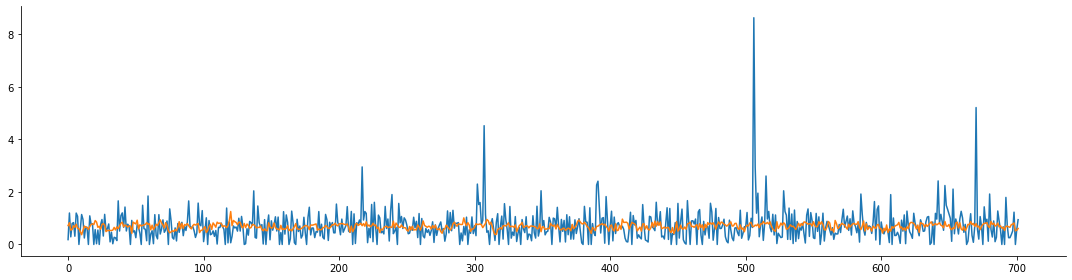

In [65]:
%matplotlib inline
plt.figure(figsize = (15, 4))
plt.plot(x2_valid[4,:,0].cpu().detach().numpy())
plt.plot(test[4,:,0].cpu().detach().numpy())